# Image Denoising Challenge

The goal for this challenge is to leverage your knowledge of Deep Learning to design and train a denoising model. For a given noisy image $X$, our model should learn to predict the denoised image $y$.


**Objectives**
- Visualize images
- Preprocess images for the neural network
- Fit a custom CNN for the task

In [18]:
# !pip install tqdm

In [185]:
from tqdm import tqdm
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.image import resize
from tensorflow.keras import layers, losses, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import mean_absolute_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from nbresult import ChallengeResult

## 1. Load Data

👉 Let's download the dataset archive.
It contains RGB and Black & White images we will be using for the rest of this challenge.

In [12]:
! curl https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/paintings.zip > paintings.zip
! unzip -nq "paintings.zip" 
! rm "paintings.zip"
! ls -l

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 90.1M  100 90.1M    0     0  6147k      0  0:00:15  0:00:15 --:--:-- 6065k 0:00:13  0:00:02 4171k     0  6055k      0  0:00:15  0:00:14  0:00:01 5141k
total 48
-rw-r--r--     1 Charlotte  staff      0 Jun 29 09:16 README.md
-rw-r--r--@    1 Charlotte  staff  23164 Jun 30 14:44 image_denoising.ipynb
drwx------  1087 Charlotte  staff  34784 Jun  9 15:06 paintings
drwxr-xr-x     3 Charlotte  staff     96 Jun 29 09:16 tests


In [13]:
!pwd

/Users/Charlotte/code/charlottesuaud/data-certification-exam/convolutional_neural_networks


In [17]:
dataset_paths = glob.glob("./paintings/*.jpg")
# dataset_paths

❓ **Display the image at index `53` of this dataset_paths (i.e the 54-th image)**

<details>
    <summary>Hint</summary>
    Use the <code>PIL.Image.open</code> and <code>matplotlib.pyplot.imshow</code> functions.
</details>

In [27]:
image_path = dataset_paths[53]
image_path

'./paintings/Rembrandt_67.jpg'

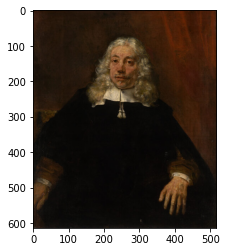

In [34]:
image = plt.imread(image_path)
plt.imshow(image);

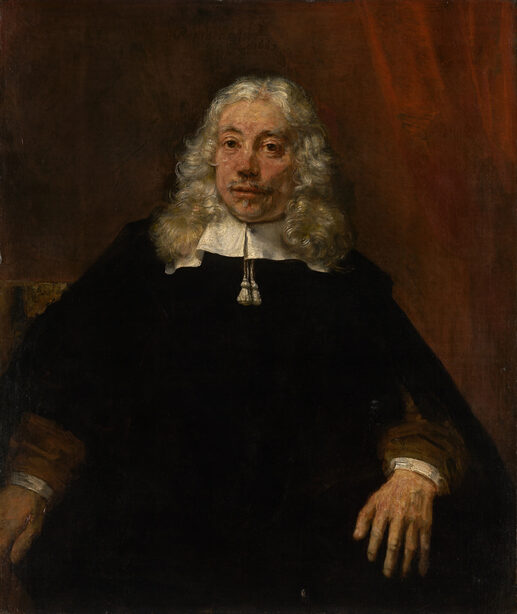

In [33]:
PIL.Image.open(image_path)

❓ **What is the shape of the image you displayed above `img_shape`?  How many dimensions `img_dim` does it have ?**

In [36]:
img_shape = image.shape
img_shape

(614, 517, 3)

In [73]:
img_dim = len(img_shape)
img_dim

3

❓ **What was in the image above?**

In [74]:
# Uncomment the correct answer

is_portrait = True
is_colored_image = True

In [75]:
result = ChallengeResult(
    'data_loading',
    img_shape=img_shape,
    img_dim=img_dim,
    is_portrait=is_portrait,
    is_colored_image=is_colored_image
)

result.write()

## 2. Processing

❓ **Store all images from the dataset folder in a list of numpy arrays called `dataset_images`**

- It can take a while
- If the dataset is too big to fit in memory, just take the first half (or quarter) of all pictures

In [115]:
print("Number of images :", len(dataset_paths))

Number of images : 1085


In [97]:
dataset_images = []

for img_path in dataset_paths:
    img = plt.imread(img_path)
    dataset_images.append(img)

In [98]:
dataset_images[0].shape

(358, 434, 3)

### 2.1 Reshape, Resize, Rescale

Let's simplify our dataset and convert it to a single numpy array

❓ **First, check if that all the images in the dataset have the same number of dimensions**.
- What do you notice?
- How do you explain it? 

In [99]:
# 1 - Checking if some images have only 1 dimension

dataset_dims = [len(img.shape) == 3 for img in dataset_images]

assert False in dataset_dims

👉 We convert for you all black & white images into 3-colored ones by duplicating the image on three channels, so as to have only 3D arrays

In [100]:
dataset_images = [x if x.ndim==3 else np.repeat(x[:,:,None], 3, axis=2) for x in tqdm(dataset_images)]
set([x.ndim for x in dataset_images])

100%|██████████| 1085/1085 [00:01<00:00, 732.48it/s]


{3}

❓ **What about their shape now ?**
- Do they all have the same width/heights ? If not:
- Resize the images (120 pixels height and 100 pixels width) in the dataset, using `tensorflow.image.resize` function.
- Now that they all have the same shape, store them as a numpy array `dataset_resized`.
- This array should thus be of size $(n_{images}, 120, 100, 3)$

In [101]:
# 2 - Checking if all images have 3 dimensions

dataset_dims = [len(img.shape) == 3 for img in dataset_images]

assert False not in dataset_dims, "Some images seem to have less than 3 dimensions!"

In [102]:
# 3 - Checking if images have different shapes

dataset_shapes = [img.shape for img in dataset_images]

assert dataset_shapes != [dataset_shapes[0]] * len(dataset_shapes)

In [104]:
# 4 - Resize images

dataset_images = [resize(img, [120,100]) for img in dataset_images]

In [112]:
# 5 - Checking what we have in dataset_images

print("dataset_images's type :", type(dataset_images))
print("dataset_images[0]'s type :", type(dataset_images[0]))
print("dataset_images[0]'s shape :", dataset_images[0].shape)

dataset_images's type : <class 'list'>
dataset_images[0]'s type : <class 'tensorflow.python.framework.ops.EagerTensor'>
dataset_images[0]'s shape : (120, 100, 3)


In [114]:
# 6 - Transforming our dataset list to a numpy array

dataset_resized = np.array(dataset_images)

print("dataset_resized's type :", type(dataset_resized))
print("dataset_resized's shape :", dataset_resized.shape)

dataset_resized's type : <class 'numpy.ndarray'>
dataset_resized's shape : (1085, 120, 100, 3)


❓ **Rescale the data of each image between $0$ and $1$**
- Save your resulting list as `dataset_scaled`

In [116]:
# 7 - Rescale 0-255 to 0-1

dataset_scaled = dataset_resized / 255.

### 2.2 Create (X,y) sets

👉 Now, we'll add for you some **random noise** to our images to simulate noise (that our model will try to remove later)

In [119]:
NOISE_LEVEL = 0.2

dataset_noisy = np.clip(
    dataset_scaled + np.random.normal(
        loc=0,
        scale=NOISE_LEVEL,
        size=dataset_scaled.shape
    ).astype(np.float32),
    0,
    1
)
dataset_noisy.shape

(1085, 120, 100, 3)

❓ **Plot a noisy image below to visualize the noise and compare it with the normal one**

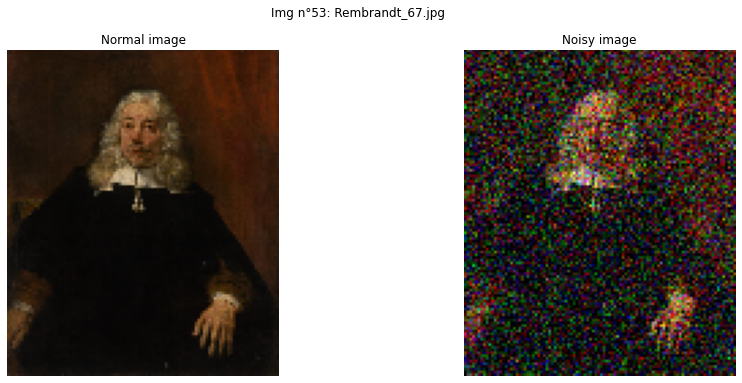

In [128]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.imshow(dataset_scaled[53])
plt.title("Normal image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(dataset_noisy[53])
plt.title("Noisy image")
plt.axis('off')

plt.suptitle(f"Img n°53: {dataset_paths[53].split('/')[-1]}");

❓ **Create your `(X_train, Y_train)`, `(X_test, Y_test)` training set for your problem**

- Remember you are trying to use "noisy" pictures in order to predict the "normal" ones.
- Keeping about `20%` of randomly sampled data as test set

In [125]:
X_train, X_test, Y_train, Y_test = train_test_split(dataset_noisy, dataset_scaled, train_size=0.8)

In [133]:
print("X_train's shape :", X_train.shape)
print("Y_train's shape :", Y_train.shape)
print("X_test's shape :", X_test.shape)
print("Y_test's shape :", Y_test.shape)

X_train's shape : (868, 120, 100, 3)
Y_train's shape : (868, 120, 100, 3)
X_test's shape : (217, 120, 100, 3)
Y_test's shape : (217, 120, 100, 3)


In [135]:
result = ChallengeResult(
    "preprocessing",
    X_train_shape = X_train.shape,
    Y_train_shape = Y_train.shape,
    X_std = X_train[:,:,:,0].std(),
    Y_std = Y_train[:,:,:,0].std(),
    first_image = Y_train[0]
)
result.write()

## 3. Convolutional Neural Network

A commonly used neural network architecture for image denoising is the __AutoEncoder__.

<img src='https://github.com/lewagon/data-images/blob/master/DL/autoencoder.png?raw=true'>

Its goal is to learn a compact representation of your data to reconstruct them as precisely as possible.  
The loss for such model must incentivize it to have __an output as close to the input as possible__.

For this challenge, __you will only be asked to code the Encoder part of the network__, since building a Decoder leverages layers architectures you are not familiar with (yet).

👉 Run this code below if you haven't managed to build your own (X,Y) training sets. This will load them as solution

```python
! curl https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_painting_solution.pickle > data_painting_solution.pickle

import pickle
with open("data_painting_solution.pickle", "rb") as file:
    (X_train, Y_train, X_test, Y_test) = pickle.load(file)
    
! rm data_painting_solution.pickle
```

### 3.1 Architecture

👉 Run the cell below that defines the decoder

In [137]:
# We choose to compress images into a latent_dimension of size 6000
latent_dimensions = 6000

# We build a decoder that takes 1D-vectors of size 6000 to reconstruct images of shape (120,100,3)
decoder = Sequential(name='decoder')
decoder.add(layers.Reshape((30, 25, 8), input_dim=latent_dimensions))
decoder.add(layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding="same", activation="relu"))
decoder.add(layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"))
decoder.add(layers.Conv2D(filters=3, kernel_size=3, padding="same", activation="sigmoid"))
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 30, 25, 8)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 60, 50, 16)        1168      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 120, 100, 32)      4640      
_________________________________________________________________
conv2d (Conv2D)              (None, 120, 100, 3)       867       
Total params: 6,675
Trainable params: 6,675
Non-trainable params: 0
_________________________________________________________________


❓ **Now, build the `encoder` that plugs correctly with the decoder defined above**. Make sure that:
- The output of your `encoder` is the same shape as the input of the `decoder`
- Use a convolutional neural network architecture without transfer learning
- Keep it simple
- Print model summary

In [147]:
encoder = Sequential(name='encoder')

encoder.add(layers.Conv2D(8, (2,2), input_shape=(120,100,3), padding="same", activation='relu'))
encoder.add(layers.MaxPool2D(2))

encoder.add(layers.Conv2D(16, (2,2), activation='relu'))
encoder.add(layers.MaxPool2D(2))

encoder.add(layers.Conv2D(32, (2,2), activation='relu'))
encoder.add(layers.MaxPool2D(2))

encoder.add(layers.Flatten())
encoder.add(layers.Dense(30*25*8, activation='tanh'))

encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 120, 100, 8)       104       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 60, 50, 8)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 59, 49, 16)        528       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 29, 24, 16)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 23, 32)        2080      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 14, 11, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 4928)              0   

👉 **Test your encoder below**

In [169]:
# HERE WE BUILD THE AUTO-ENCODER (ENCODER + DECODER) FOR YOU. IT SHOULD PRINT A NICE SUMMARY

x = layers.Input(shape=(120, 100, 3))
autoencoder = Model(x, decoder(encoder(x)), name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 120, 100, 3)]     0         
_________________________________________________________________
encoder (Sequential)         (None, 6000)              29576712  
_________________________________________________________________
decoder (Sequential)         (None, 120, 100, 3)       6675      
Total params: 29,583,387
Trainable params: 29,583,387
Non-trainable params: 0
_________________________________________________________________


### 3.2 Training

❓ **Before training the autoencoder, evaluate your baseline score**
- We will use the mean absolute error in this challenge
- Compute the baseline score on your test set in the "stupid" case where you don't manage to de-noise anything at all.
- Store the result under `score_baseline`

In [170]:
# if we don't denoize anything, then y_pred = X_train (noized pictures) and y_true = Y_train

score_baseline = np.mean(mean_absolute_error(X_train, Y_train))
score_baseline

0.1409436

❓ Now, **train your autoencoder**

- Use an appropriate loss
- Adapt the learning rate of your optimizer if convergence is too slow/fast
- Make sure your model does not overfit with appropriate control techniques

💡 You will not be judged by the computing power of your computer, you can reach decent performance in less than 5 minutes of training without GPUs.

In [171]:
opt = Adam(learning_rate=0.01)

# we want to penalize high errors 
# ("The loss for such model must incentivize it to have an output as close to the input as possible")
# => so we can use 'mse' loss, and keep 'mae' metric to see errors in target dimension

autoencoder.compile(
    loss='mse', 
    optimizer=opt,
    metrics=['mae'])

In [172]:
es = EarlyStopping(patience=5, restore_best_weights=True)

history = autoencoder.fit(X_train, Y_train, 
          batch_size = 32,
          epochs=100,
          validation_split=0.3,
          callbacks=[es])

Epoch 1/100
19/19 [==============================] - 21s 1s/step - loss: 0.0469 - mae: 0.1736 - val_loss: 0.0407 - val_mae: 0.1624
Epoch 2/100
19/19 [==============================] - 21s 1s/step - loss: 0.0325 - mae: 0.1407 - val_loss: 0.0315 - val_mae: 0.1366
Epoch 3/100
19/19 [==============================] - 21s 1s/step - loss: 0.0271 - mae: 0.1254 - val_loss: 0.0291 - val_mae: 0.1296
Epoch 4/100
19/19 [==============================] - 23s 1s/step - loss: 0.0242 - mae: 0.1171 - val_loss: 0.0271 - val_mae: 0.1250
Epoch 5/100
19/19 [==============================] - 18s 970ms/step - loss: 0.0220 - mae: 0.1110 - val_loss: 0.0266 - val_mae: 0.1247
Epoch 6/100
19/19 [==============================] - 18s 934ms/step - loss: 0.0202 - mae: 0.1060 - val_loss: 0.0258 - val_mae: 0.1207
Epoch 7/100
19/19 [==============================] - 18s 951ms/step - loss: 0.0184 - mae: 0.1007 - val_loss: 0.0250 - val_mae: 0.1164
Epoch 8/100
19/19 [==============================] - 18s 952ms/step - loss

❓ **Plot your training and validation loss at each epoch using the cell below**

In [180]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train loss' + exp_name)
    ax1.plot(history.history['val_loss'], label='val loss' + exp_name)
    ax1.set_ylim(0., 0.06)
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history.history['mae'], label='train mae'  + exp_name)
    ax2.plot(history.history['val_mae'], label='val mae'  + exp_name)
    ax2.set_ylim(0., 0.2)
    ax2.set_title('MAE')
    ax2.legend()
    return (ax1, ax2)

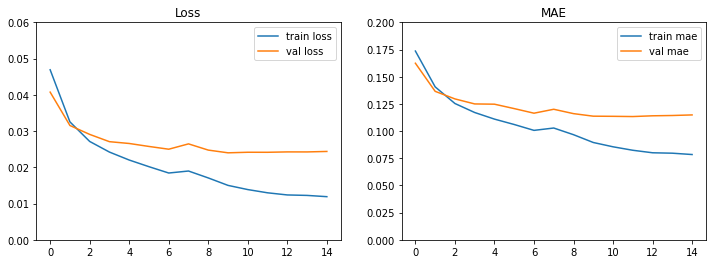

In [181]:
# Plot below your train/val loss history
plot_history(history)

# Run also this code to save figure as jpg in path below (it's your job to ensure it works)
fig = plt.gcf()
plt.savefig("tests/history.png")

❓ **Evaluate your performances on test set**
- Compute your de-noised test set `Y_pred` 
- Store your test score as `score_test`
- Plot a de-noised image from your test set and compare it with the original and noisy one using the cell below

In [182]:
Y_pred = autoencoder.predict(X_test)
score_test = np.mean(mean_absolute_error(Y_pred, Y_test))
score_test

0.11465658

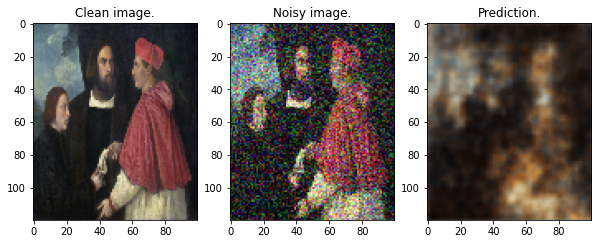

In [183]:
# RUN THIS CELL TO CHECK YOUR RESULTS
idx = 0

fig, axs = plt.subplots(1,3, figsize=(10,5))
axs[0].imshow(Y_test[idx])
axs[0].set_title("Clean image.")

axs[1].imshow(X_test[idx])
axs[1].set_title("Noisy image.")

axs[2].imshow(Y_pred[idx])
axs[2].set_title("Prediction.")

# Run this to save your results for correction
plt.savefig('tests/image_denoised.png')

🧪 **Send your results below**

In [186]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "network",
    input_shape = list(encoder.input.shape),
    output_shape = list(encoder.output.shape),
    layer_names = [layer.name for layer in encoder.layers],
    trainable_params = sum([tf.size(w_matrix).numpy() for w_matrix in encoder.trainable_variables]),
    score_baseline = score_baseline,
    score_test = score_test,
)
result.write()